## 基于经典网络架构训练图像分类模型
### 数据预处理部分：
- 数据增强：torchvision 中 transforms 模块自带功能
- 数据预处理： torchvision 中 transforms
- DataLoader 模块直接读取 batch 数据

### 网络模块设置
- 加载预训练模型，torchvision 中有很多经典网络架构，可以用训练好的权重参数来继续训练（迁移学习）
- 注意：别人训练好的任务不一定跟自己的任务一样，需要把最后的 head 层改一改，一般也是最后的全连接层，改成自己的任务
- 训练时可以全部从头训练，也可以只训练关于自己任务的层，因为前几层都是做特征提取的，本质任务目标是一致的

### 网络模型保存与测试
- 模型保存的时候可以带有选择性，例如在验证集中如果当前效果好则保存
- 读取模型进行实际测试

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

### 数据读取与预处理操作

In [2]:
data_dir = 'D:/ML/QCIT/QCIT_FireSmokeDetectionDataset/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

### 制作数据源
- data_transforms 中指定了所有图像预处理操作
- ImageFolder 假设所有的文件按文件夹保存好，每个文件夹下面存储同一类别的图片，文件夹的名字为分类的名字

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),              # 随机旋转，-45到45度之间随机
        transforms.CenterCrop(224),                 # 从中心开始裁剪
        transforms.RandomHorizontalFlip(p=0.5),     # 随机水平翻转，选择一个概率
        transforms.RandomVerticalFlip(p=0.5),       # 随机垂直翻转
        transforms.ColorJitter(                     # 颜色
            brightness=0.2,                         # 亮度
            contrast=0.1,                           # 对比度
            saturation=0.1,                         # 饱和度
            hue=0.1),                               # 色相
        transforms.RandomGrayscale(p=0.025),        # 概率转换成灰度图，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize(                       # 迁移学习
            [0.485, 0.456, 0.406],                  # 均值
            [0.229, 0.224, 0.225])                  # 标准差
    ]),

    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225])
    ])
}


In [4]:
batch_size = 8

image_datasets = {X : datasets.ImageFolder(os.path.join(data_dir, X), data_transforms[X]) for X in ['train', 'valid']}
dataLoaders = {X : torch.utils.data.DataLoader(image_datasets[X], batch_size=batch_size, shuffle=True) for X in ['train', 'valid']}
dataset_sizes = {X : len(image_datasets[X]) for X in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [6]:
print('{}\n\n{}\n\n{}\n\n{}'.format(image_datasets, dataLoaders, dataset_sizes, class_names))

{'train': Dataset ImageFolder
    Number of datapoints: 3129
    Root location: D:/ML/QCIT/QCIT_FireSmokeDetectionDataset/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomGrayscale(p=0.025)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'valid': Dataset ImageFolder
    Number of datapoints: 782
    Root location: D:/ML/QCIT/QCIT_FireSmokeDetectionDataset/valid
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialia

### 数据展示
Tensor 的数据需要转换成 numpy 格式， 而且还需要还原回标准化的结果

In [6]:
def im_convert(tensor):
    '''展示数据'''

    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image


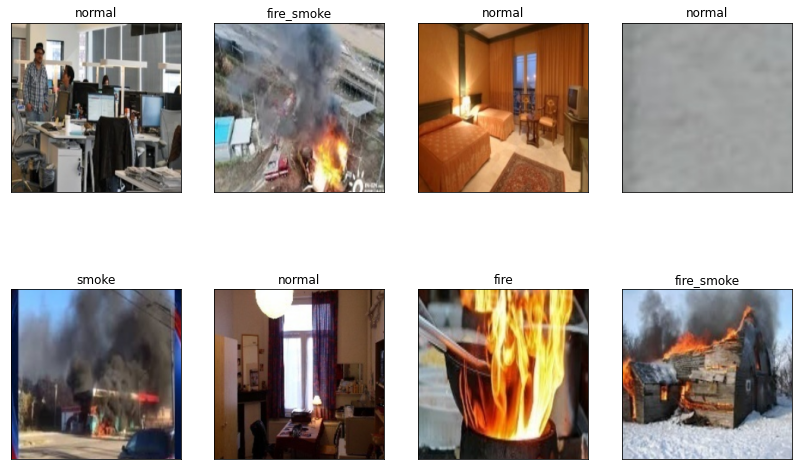

In [7]:
fig = plt.figure(figsize=(14,9))
columns = 4
rows = 2

dataiter = iter(dataLoaders['valid'])
inputs, classes = dataiter.next()

for idx in range(columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(class_names[classes[idx]])
    plt.imshow(im_convert(inputs[idx]))
plt.show()


#### 加载预训练模型，并且直接用训练好的权重当作初始化参数

In [8]:
model_name = 'resnet'
# 是否用训练好的特征来做
feature_extract = True

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
model_ft = models.resnet152()

In [12]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == 'resnet':
        '''ResNet152'''
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.LogSoftmax(dim=1))

        input_size = 224

    return model_ft, input_size


#### 设置哪些层需要训练

In [14]:
model_ft, input_size = initialize_model(model_name, 4, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

# 模型保存
filename = 'checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print('Params to learn:')
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t', name)

else:
    for name, param in model_ft.parameters():
        if param.requires_grad == True:
            print('\t', name)

Params to learn:
	 fc.0.weight
	 fc.0.bias


#### 优化器设置

In [15]:
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
# 学习率每 7 个 epoch 衰减为原来的 1/10
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# 最后一层已经 LogSoftmax() 了，所以不能 nn.CrossEntropyLoss() 来计算了
# nn.CrossEntropyLoss() 相当于 nn.LogSoftmax() 和 nn.NLLLoss() 整合
criterion = nn.NLLLoss()

#### 训练模块

In [16]:
def train_model(model, dataLoaders, criterion, optimizer, num_epochs=25, filename=filename):
    since = time.time()
    best_acc = 0

    # checkpoint = torch.load(filename)
    # best_acc = checkpoint['best_acc']
    # model.load_state_dict(checkpoint['state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer'])
    # model.class_to_idx = checkpoint['mapping']

    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # 把数据遍历
            for inputs, labels in dataLoaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataLoaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataLoaders[phase].dataset)

            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f}  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 得到最好的一次模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict' : model.state_dict(),
                    'best_acc' : best_acc,
                    'optimizer' : optimizer.state_dict()
                }
                torch.save(state, filename)

            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)

        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc : {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs


#### 开始训练

In [17]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(
    model_ft, dataLoaders, criterion, optimizer_ft, num_epochs=5, filename=filename)

Epoch 0/4
----------
Time elapsed 3m 35s
train Loss: 1.6404  Acc: 0.6478
Time elapsed 4m 22s
valid Loss: 2.9067  Acc: 0.5153


C:\Users\ssm\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Optimizer learning rate : 0.0100000

Epoch 1/4
----------
Time elapsed 7m 45s
train Loss: 2.0538  Acc: 0.7025
Time elapsed 8m 27s
valid Loss: 1.9516  Acc: 0.7033
Optimizer learning rate : 0.0100000

Epoch 2/4
----------
Time elapsed 11m 50s
train Loss: 1.7405  Acc: 0.7376
Time elapsed 12m 31s
valid Loss: 2.2506  Acc: 0.6854
Optimizer learning rate : 0.0100000

Epoch 3/4
----------
Time elapsed 15m 54s
train Loss: 1.9325  Acc: 0.7341
Time elapsed 16m 37s
valid Loss: 1.2872  Acc: 0.8133
Optimizer learning rate : 0.0100000

Epoch 4/4
----------
Time elapsed 20m 0s
train Loss: 1.8603  Acc: 0.7555
Time elapsed 20m 41s
valid Loss: 1.9182  Acc: 0.7737
Optimizer learning rate : 0.0100000

Training complete in 20m 41s
Best val Acc : 0.813299


#### 再训练所有层

In [16]:
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所以的参数，学习率调小一点
optimizer = optim.Adam(params_to_update, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

criterion = nn.NLLLoss()

In [17]:
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(
    model_ft, dataLoaders, criterion, optimizer_ft, num_epochs=5, filename=filename)

#### 测试网络效果
#### 加载训练好的模型

In [20]:
model_ft, input_size = initialize_model(model_name, 4, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

filename = 'checkpoint.pth'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [21]:
x = range(41)


range(0, 41)